In [4]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [5]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

데이터


In [32]:
data= pd.read_csv('./000660.csv')

def dataRename(data):
    data=data[['종가','매도량','매수량']]
    data.rename(columns={
                                '종가' : 'close',
                                '매도량' : 'sell',
                                '매수량' : 'buy',
                            }, inplace=True)
    return data

data2=dataRename(data)
data2.head()

C:\Users\F06\AppData\Local\Temp\ipykernel_22336\457760488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={


,close,sell,buy
0,90000,4524.0,6214.0
1,90200,4379.0,21092.0
2,90300,143.0,10027.0
3,90300,7532.0,18925.0
4,90300,604.0,938.0


In [114]:
data = pd.read_csv('./000660.csv')
confirmed=dataRename(data)
# confirmed[confirmed['Code']=='원하는 코드'] 이건 전체데이터 로드할때 쓰는거에용
daily_cases = confirmed.diff().fillna(confirmed.iloc[0]).astype('int')
daily_cases

C:\Users\F06\AppData\Local\Temp\ipykernel_22336\457760488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={


,close,sell,buy
0,90000,4524,6214
1,200,-145,14878
2,100,-4236,-11065
3,0,7389,8898
4,0,-6928,-17987
...,...,...,...
17385,-200,1709,-20007
17386,0,2212,-2570
17387,-200,30495,52023
17388,300,-36057,-36775


In [116]:
confirmed['backClose'] = confirmed['close'].shift(1)
confirmed['backClose'] = confirmed['backClose'].fillna(confirmed['close'])
confirmed['taget'] = confirmed.apply(lambda row: 1 if row['close'] > row['backClose'] 
                                 else (0 if row['close'] == row['backClose'] 
                                 else 2), axis=1)
confirmed.drop(['backClose'],inplace=True , axis=1)
confirmed

C:\Users\F06\AppData\Local\Temp\ipykernel_22336\568399270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed['backClose'] = confirmed['close'].shift(1)
C:\Users\F06\AppData\Local\Temp\ipykernel_22336\568399270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed['backClose'] = confirmed['backClose'].fillna(confirmed['close'])
C:\Users\F06\AppData\Local\Temp\ipykernel_22336\568399270.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,close,sell,buy,taget
0,90000,4524.0,6214.0,0
1,90200,4379.0,21092.0,1
2,90300,143.0,10027.0,1
3,90300,7532.0,18925.0,0
4,90300,604.0,938.0,0
...,...,...,...,...
17385,172900,20368.0,9388.0,2
17386,172900,22580.0,6818.0,0
17387,172700,53075.0,58841.0,2
17388,173000,17018.0,22066.0,1


In [34]:
data = pd.read_csv('./000660.csv')
confirmed=dataRename(data)
# confirmed[confirmed['Code']=='원하는 코드'] 이건 전체데이터 로드할때 쓰는거에용
daily_cases = confirmed.diff().fillna(confirmed.iloc[0]).astype('int')

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 1
X, y = create_sequences(daily_cases, seq_length)

#학습용, 검증용, 시험용으로 분리
train_size = int(327 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

#MinMax 스케일링
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

#Tensor 형태로 변환
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

C:\Users\F06\AppData\Local\Temp\ipykernel_22336\457760488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={


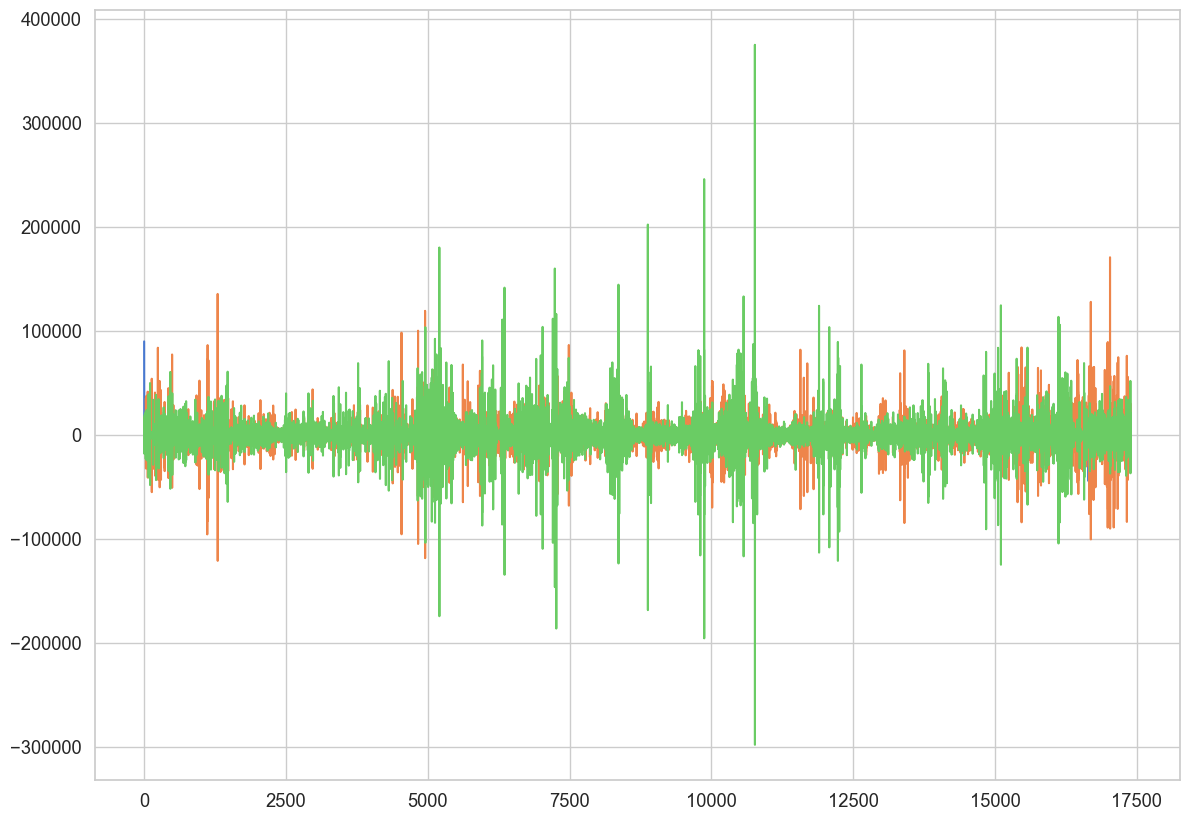

In [35]:
plt.plot(daily_cases.values)

In [61]:
data.shape

(17390, 20)

In [66]:
c = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1)
input = torch.Tensor([[[1, 2, 3, 4, 5]]])
# 텐서를 (5, 1, 1)로 변형
reshaped = input.view(5, 1, 1)
input = reshaped.expand(-1, -1, 3)
output = c(input)
output

tensor([[[1.1815, 1.1815]],

        [[1.8577, 1.8577]],

        [[2.5340, 2.5340]],

        [[3.2103, 3.2103]],

        [[3.8866, 3.8866]]], grad_fn=<ConvolutionBackward0>)

In [68]:
print(input.shape)  

torch.Size([5, 1, 3])


In [69]:
for param in c.parameters():
    print(param)

Parameter containing:
tensor([[[0.3554, 0.3209]]], requires_grad=True)
Parameter containing:
tensor([0.5052], requires_grad=True)


In [70]:
w_list = []
for param in c.parameters():
    w_list.append(param)

w = w_list[0]
b = w_list[1]

w1 = w[0][0][0]
w2 = w[0][0][1]

print(w1)
print(w2)
print(b)

tensor(0.3554, grad_fn=<SelectBackward0>)
tensor(0.3209, grad_fn=<SelectBackward0>)
Parameter containing:
tensor([0.5052], requires_grad=True)


In [71]:
w1 * 3 + w2 * 4 + b

tensor([2.8549], grad_fn=<AddBackward0>)

In [89]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size = 2, stride = 1) # 1D CNN 레이어 추가
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len-1, self.n_hidden)
        )
    def forward(self, sequences):
        sequences = self.c1(sequences.view(len(sequences), 1, -1))
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len-1, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len-1, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [94]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose=10, patience=10):
    loss_fn = torch.nn.L1Loss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    
    for t in range(num_epochs):
        epoch_loss = 0
        for idx, seq in enumerate(train_data):
            model.reset_hidden_state()
            # train loss
            seq = seq.unsqueeze(0)  # (1, 5)로 변형
            seq = seq.view(5, 1, 3)  # (5, 1, 3)으로 reshape (입력 데이터의 크기에 따라 조정 필요)
            y_pred = model(seq)
            loss = loss_fn(y_pred.view(-1), train_labels[idx])  # 예측 결과를 flatten
            
            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))
        
        if val_data is not None:
            with torch.no_grad():
                val_loss = 0
                for val_idx, val_seq in enumerate(val_data):
                    model.reset_hidden_state()
                    val_seq = val_seq.unsqueeze(0)  # (1, 5)로 변형
                    val_seq = val_seq.view(5, 1, 3)  # (5, 1, 3)으로 reshape
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred.view(-1), val_labels[val_idx])  # 예측 결과를 flatten
                    val_loss += val_step_loss
        
            val_hist.append(val_loss / len(val_data))

            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')
                
            if (t % patience == 0) & (t != 0):
                if val_hist[t - patience] < val_hist[t]:
                    print('\n Early Stopping')
                    break
        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

    return model, train_hist, val_hist


In [95]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)

In [96]:
print(model)

CovidPredictor(
  (c1): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
  (lstm): LSTM(1, 4)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


In [117]:
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

RuntimeError: shape '[5, 1, 3]' is invalid for input of size 3